In [1]:
%%time
dataset_name = "W20_comb"
df_list = "BES_Panel"

%matplotlib inline
%run BES_header.py {dataset_name} {df_list}
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# # pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
# pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
# pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

Wall time: 53.4 s


In [2]:
# search(BES_Panel,"wt")

In [3]:
# search(BES_Panel,"vote")

In [4]:
pattern = "enviroGrowth|econ(Personal|Gen)(Retro|Prosp)|goodTimePurchase|"
pattern = pattern + "privateEnterprise|stateOwnership|jobForAll|" # bhpsIdeology
pattern = pattern + "lockdownApproval|cvEcon|govtCorpSupport|worryCoronaEcon|" # corona-related
pattern = pattern + "worryEconSecurity|borrowEssentials|smallEmergency|riskPoverty|riskUnemployment|" # econ risks
pattern = pattern + "reasonForUnemployment|govtHandouts|businessBonus|" # perceptions of the poor
pattern = pattern + "economyResponsible|responsibleDebt|" # responsible for economy/debt
pattern = pattern + "(change|responsible|govtHandle|labHandle)(Econ|CostLive)|" # change/resp/handle Econ/CostLive
pattern = pattern + "cutsTooFar|privatTooFar|enviroProtection|tuitionFeesTooFar|" # too-far list
pattern = pattern + "automation|globalGoodOverall|global(Trade|Banks|Migration|Tourism|Planes|Films|Brands|Talk|Orgs)|" # auto/globalization
pattern = pattern + "socialCare|zeroHourContract|renationaliseRail|debtMoral|" # specific economic policies
pattern = pattern + "redist|selfRedistCertain|taxSpend|tax(High|Medium|Low)Income|spend(Health|Pensions|Unemp)|" # taxation and redist
pattern = pattern + "deficitReduce|howToReduceDeficit|" # must you/how to reduce deficit
pattern = pattern + "tryReduceInequality|successReduceInequality|inequality|" # inequality good/bad/changing party perception
pattern = pattern + "minIncomeWellOff|minIncomeGetBy|incomeWelfare|welfarePreference|" # questions about minimum income/perceived levels
pattern = pattern + "(con|lab|brexit|snp|pc|ukip|grn)LookAfter|"
pattern = pattern + "lr\d"
# pattern = pattern +
# pattern = pattern +




# sdoantiegal|sdodominance|zeroSum|
# radical|harkBack|

# localEconNow|
# localEcon1520Yr

In [5]:
matches = search(BES_Panel,pattern)

In [6]:
pd.Series([re.search("(W\d.*)",x).groups()[0] for x in matches.index]).value_counts()

W4         88
W20        77
W2         70
W3         63
W1         63
W10        46
W14        42
W6         39
W7         36
W12        35
W15        34
W19        34
W17        33
W16        26
W11        20
W18        18
W13        17
W8          7
W7_W9       5
W1_W5       5
W14W15      5
W10_W12     5
W9          4
dtype: int64

In [7]:
# BES_Panel[matches.index].columns[ BES_Panel[matches.index].describe().loc["unique"]>100 ]

In [8]:
df = BES_Panel[matches.index].copy()

In [9]:
# df['minIncomeWellOffW1']

In [10]:
minIncomeVars = BES_Panel[matches.index].columns[ BES_Panel[matches.index].describe().loc["unique"]>15 ]

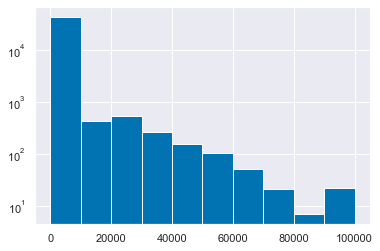

In [11]:
df[minIncomeVars].stack().replace("Don't know",np.nan).hist(log=True)

In [12]:
minIncomeVarsAdditional = list(minIncomeVars)

for x in minIncomeVars:

    df[x+"_dk"] = df[x]=="Don't know"
    df[x+"_na"] = df[x].isnull()
    df[x] = df[x].replace("Don't know",np.nan).astype(float).fillna(df[x].replace("Don't know",np.nan).astype(float).mean())
    minIncomeVarsAdditional.append(x+"_dk")
    minIncomeVarsAdditional.append(x+"_na")

In [13]:
dummied_vars = pd.get_dummies(df[[y for y in df.columns if y not in minIncomeVarsAdditional]],dummy_na=True)

In [14]:
df_nona = pd.concat([df[minIncomeVarsAdditional],dummied_vars],axis=1)

In [15]:
df_nona.dtypes.value_counts()

uint8      5736
bool         30
float64      15
dtype: int64

In [16]:
%%time

Treatment = "Economic Policy Variables"
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

# value_vars = [x for x in manifesto_project.columns if re.match("per(\d+|uncod)|rile|planeco|markeco|welfare|intpeace",x)]
# value_vars = search(BES_reduced_with_na,"taxSpend|tax(Low|Middle|High)Income|bes(1|2|3|4)(a|b)W2|socialCare|howToReduceDeficit|deficitReduce|spend(Health|Pensions|Unemp)").index
# rile, planeco, markeco, welfare, intpeace
# notnulls = BES_reduced_with_na[value_vars].notnull().any(axis=1)
# notnulls = BES_reduced_with_na["taxLowIncomeW15__Much too high"].notnull()
# MCP_vals = BES_reduced_with_na[value_vars][notnulls]
# MCP_vals = MCP_vals.fillna(MCP_vals.mean())


# df["peruncod"]
# percentage uncoded
# MCP_vals.columns = [variable_labels.loc[x]+"("+x.replace("per","")+")" for x in MCP_vals.columns]
# MCP_vals.columns
# MCP_vals = MCP_vals.drop_duplicates()
MCP_vals = df_nona.drop_duplicates()

decomp_index = MCP_vals.index
decomp_columns = MCP_vals.columns
clean_feature_set_std = StandardScaler().fit_transform(MCP_vals.values )
decomp_std = pd.DataFrame(   clean_feature_set_std,
                             columns = MCP_vals.columns,
                             index   = MCP_vals.index      )



# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = decomp_std.shape[1]
n_components = 5
# (svd_solver='full', n_components='mle',whiten=True)
decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

# decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(decomp_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = decomp_index)


# import pickle
# # treatdir = BES_data_folder+Treatment
# # subdir = BES_data_folder+Treatment+decomp_method
# load_suff = "FactorAnalysis"
# save = True # False => Load

# if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
#     decomp_method = str(decomp).split("(")[0] 
#     subdir = output_subfolder + decomp_method
#     fname = subdir+ os.sep + decomp_method
#     # create dir, save decomp object, BES_decomp, BES_std    
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     decomp_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
# else: # LOAD decomp results (default is SAVE)
#     decomp_method = load_suff
#     subdir = output_subfolder + os.sep + decomp_method    
#     fname = subdir + os.sep + decomp_method
#     if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
#     # load decomp object, BES_decomp, BES_std, n_components
#     with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
#     BES_decomp = pd.read_hdf(fname+".hdf")
#     decomp_std    = pd.read_hdf(fname+"_std"+".hdf")
#     n_components = decomp.components_.shape[0] 
    
subdir = output_subfolder + decomp_method
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          decomp_columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 7, show_histogram = False)    

NameError: name 'subdir' is not defined

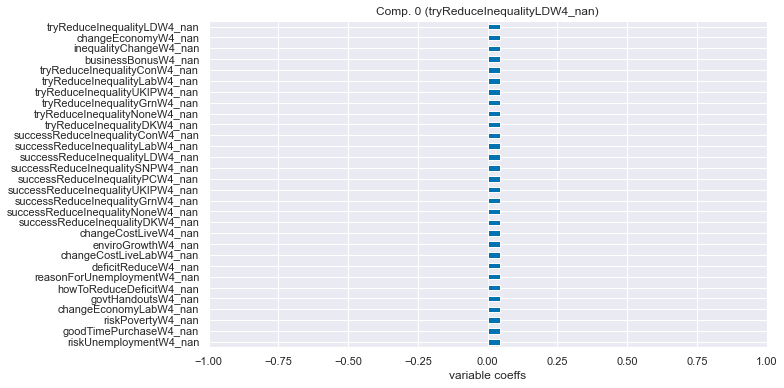

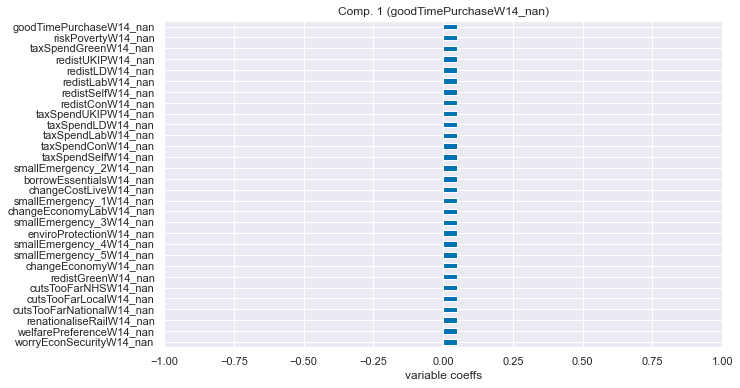

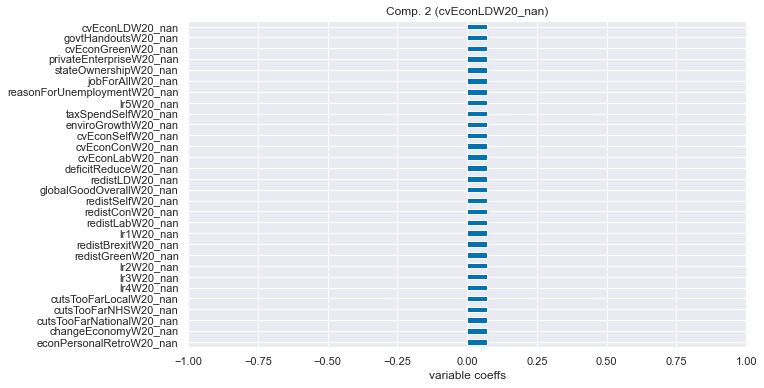

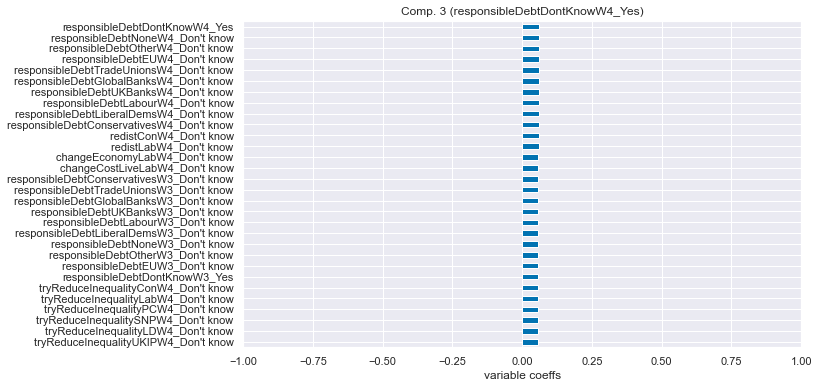

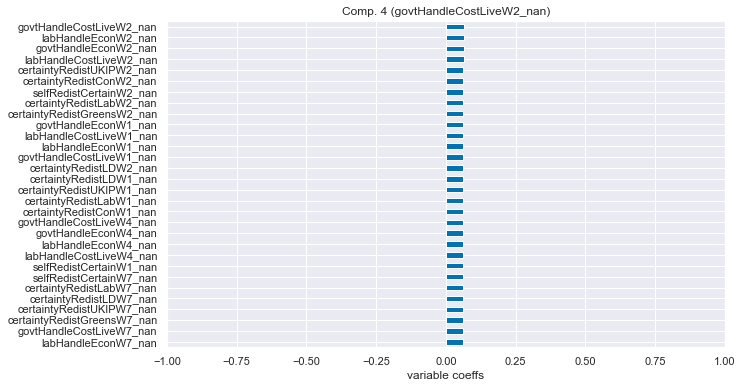

In [18]:
subdir = output_subfolder + decomp_method
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          decomp_columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 7, show_histogram = False)  

In [ ]:
MCP_vals.shape